# 1 - Estimate when US Installs will reach EoL


Historical installations for U.S. Utility and non-Residential sector was calculated from
1. L. Sherwood, “U.S. Solar Market Trends 2008,” Interstate Renewable Energy Council, Jul. 2009. Accessed: Sep. 15, 2021. [Online]. Available: https://irecusa.org/wp-content/uploads/2021/07/Solar-Market-Trends-2008.pdf
2. All Sherwood reports 2009-2014 for 1999 through 2009
3. Wood Mackenzie Data from 2010 forward.
4. “U.S. Solar Market Insight Report: 2012 Year in Review Full Report,” Greentech Media Inc. & SEIA, 2013 as a sanity check.
The calculations to select for only these 2 sectors and weight for c-Si can be found in Supporting Materials folder, files "Calculations-Installs-Subset-CommUtility.xlsx", "Installs-SubsetCommUtility.xlsx", and "Installs-SubsetCommUtility.csv".

These installations where then put into a module file. Installations after 2020 are set to 0, manufacturing efficiency is set to 100, and all circular EoL pathways are set to 0, sending all EoL material to the landfill. All lifetime and reliability, module efficiencies, and module degradation rates are taken from PV ICE baseline. The purpose of this calculation is to estimate when currently installed PV modules will come out of the field and need to be managed at EoL.


This analysis conducted for Taylor Curtis

In [1]:
import os
from pathlib import Path
import PV_ICE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')

# Another option using relative address; for some operative systems you might need '/' instead of '\'
# testfolder = os.path.abspath(r'..\..\PV_DEMICE\TEMP')  

print ("Your simulation will be stored in %s" % testfolder)

Your simulation will be stored in C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP


In [2]:
PV_ICE.__version__

'v0.2.0+223.ge0bffee.dirty'

### Add Scenarios and Materials


In [3]:
cwd=os.getcwd()
print(os.getcwd())

C:\Users\hmirletz\Documents\GitHub\PV_ICE\docs\tutorials


In [4]:
MATERIALS = ['glass','aluminium_frames','silver','silicon', 'copper', 'encapsulant', 'backsheet']
MATERIAL = MATERIALS[0]
moduleFile = r'..\baselines\baseline_modules_mass_US_HistoryUtilCommOnly.csv'

In [5]:
r1 = PV_ICE.Simulation(name='Simulation1', path=testfolder)
r1.createScenario(name='USHistory', massmodulefile=moduleFile)
for mat in range (0, len(MATERIALS)):
    MATERIALBASELINE = r'..\baselines\baseline_material_mass_'+MATERIALS[mat]+'.csv'
    r1.scenario['USHistory'].addMaterial(MATERIALS[mat], massmatfile=MATERIALBASELINE)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP


### Set All Material Virgin, MFG, and circularity to 0

The effective this will be to neglect all inefficiencies in the extraction and manufacturing process, looking at just the PV module material coming out of the field, and assuming it all goes to the landfill.

In [6]:
r1.scenMod_noCircularity() # sets all module and material circular variables to 0, creating fully linear
r1.scenMod_PerfectManufacturing() #sets all manufacturing values to 100% efficiency/yield
#check:
#r1.scenario['USHistory'].material['glass'].materialdata['mat_MFG_eff']

### Run the Mass Flow Calculations on All Scenarios and Materials

In [7]:
r1.calculateMassFlow()


>>>> Calculating Material Flows <<<<

Working on Scenario:  USHistory
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  aluminium_frames
==> Working on Material :  silver
==> Working on Material :  silicon
==> Working on Material :  copper
==> Working on Material :  encapsulant
==> Working on Material :  backsheet


###  Use internal plotting functions to plot results

Pull out the keywords by printing the keys to the module data or the material data:

    print(r1.scenario.keys())
    
    print(r1.scenario['standard'].data.keys())
    
    print(r1.scenario['standard'].material['glass'].materialdata.keys())

In [8]:
#print(r1.scenario.keys())
print(r1.scenario['USHistory'].dataOut_m.keys())
#print(r1.scenario['USHistory'].material['glass'].materialdata.keys())

Index(['Area', 'Area_for_EOL_pathsG', 'Cumulative_Active_Area', 'EOL_BS_Year0',
       'EOL_BS_Year1', 'EOL_BS_Year10', 'EOL_BS_Year11', 'EOL_BS_Year12',
       'EOL_BS_Year13', 'EOL_BS_Year14',
       ...
       'Status_BAD_[W]', 'WeibullParams', 'Yearly_Sum_Area_disposed',
       'Yearly_Sum_Area_disposedby_Failure',
       'Yearly_Sum_Area_disposedby_ProjectLifetime',
       'Yearly_Sum_Power_disposed', 'Yearly_Sum_Power_disposedby_Failure',
       'Yearly_Sum_Power_disposedby_ProjectLifetime', 'irradiance_stc',
       'landfilled_noncollected'],
      dtype='object', length=209)


In [9]:
r1.plotScenariosComparison(keyword='Yearly_Sum_Area_disposed')

AttributeError: 'Scenario' object has no attribute 'dataIn_e'

<Figure size 432x288 with 0 Axes>

In [10]:
r1.plotMaterialComparisonAcrossScenarios(material='glass', keyword='mat_Total_MFG_Landfilled')

TypeError: argument of type 'NoneType' is not iterable

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Installed Cap [W]')

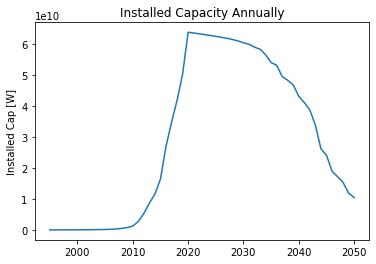

In [11]:
plt.plot(r1.scenario['USHistory'].dataIn_m['year'], 
         r1.scenario['USHistory'].dataOut_m['Installed_Capacity_[W]'], label='Installed [W]')

plt.title('Installed Capacity Annually')
plt.ylabel('Installed Cap [W]')

In [12]:
usyearlyr1, uscumr1 = r1.aggregateResults()
usyearlyr1.to_csv('historicalUS-yearly.csv')
uscumr1.to_csv('historicalUS-cumulative.csv')

## Pretty Plots

In [15]:
#create a yearly Module Waste Mass
USyearly=pd.DataFrame()
keyword = 'mat_Total_Landfilled'
for mat in range (0, len(MATERIALS)):
    material = MATERIALS[mat]
    foo = r1.scenario['USHistory'].material[material].matdataOut_m[keyword].copy()
    foo = foo.to_frame(name=material)
    USyearly["Waste_"+material] = foo[material]

#sum the columns for module mass
USyearly['Waste_Module'] = USyearly.sum(axis=1)

USyearly.head(10)

,Waste_glass,Waste_aluminium_frames,Waste_silver,Waste_silicon,Waste_copper,Waste_encapsulant,Waste_backsheet,Waste_Module
0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
1,2.620761e+03,1.008931e+03,29.464807,2.813476e+02,1.800032,2.832639e+02,60.268924,4.285837e+03
2,5.527447e+04,2.126104e+04,620.568471,5.929703e+03,37.964478,5.974321e+03,1272.783717,9.037085e+04
3,3.194365e+05,1.226027e+05,3573.605687,3.420721e+04,219.400390,3.452618e+04,7379.580016,5.219452e+05
4,1.069380e+06,4.097185e+05,11929.573073,1.143532e+05,734.488196,1.155835e+05,24768.574188,1.746468e+06
5,2.652191e+06,1.014814e+06,29528.414434,2.833293e+05,1821.619507,2.866611e+05,61539.374804,4.329885e+06
6,5.469084e+06,2.090106e+06,60797.006105,5.838039e+05,3756.361575,5.911239e+05,127077.121714,8.925748e+06
7,9.963942e+06,3.802704e+06,110609.055889,1.062870e+06,6843.590824,1.076949e+06,231809.946600,1.625573e+07
8,1.660546e+07,6.326748e+06,184065.360499,1.770048e+06,11405.222120,1.794795e+06,386828.598029,2.707935e+07
9,2.585632e+07,9.830306e+06,286115.909822,2.753878e+06,17759.041405,2.794671e+06,603218.561259,4.214227e+07


In [ ]:
#add index
USyearly.index = r1.scenario['USHistory'].dataIn_m['year']

In [ ]:
#Convert to million metric tonnes
USyearly_mil_tonnes=USyearly/1000000000000

In [ ]:
#Adding new installed capacity for decomissioning calc
USyearly_mil_tonnes['new_Installed_Capacity_[MW]'] = r1.scenario['USHistory'].dataIn_m['new_Installed_Capacity_[MW]'].values

In [ ]:
UScum = USyearly_mil_tonnes.copy()
UScum = UScum.cumsum()

UScum.head()

In [ ]:
bottoms = pd.DataFrame(UScum.loc[2050])
bottoms

In [ ]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (15, 8)

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

########################    
# SUBPLOT 1
########################
a0.plot(USyearly_mil_tonnes.index, USyearly_mil_tonnes['Waste_Module'], 'k.', linewidth=5, label='EoL Module Mass')
a0.plot(USyearly_mil_tonnes.index, USyearly_mil_tonnes['Waste_glass'], 'k', linewidth=5, label='EoL Glass Mass')
a0.fill_between(USyearly_mil_tonnes.index, USyearly_mil_tonnes['Waste_glass'], USyearly_mil_tonnes['Waste_Module'],
                color='k', alpha=0.3, interpolate=True)

a0.legend()
a0.set_title('Yearly EoL Material Mass')
a0.set_ylabel('Mass [Million Tonnes]')
a0.set_xlim([1995, 2050])
a0.set_xlabel('Years')

########################    
# SUBPLOT 2
########################
## Plot BARS Stuff
ind=np.arange(1)
width=0.35 # width of the bars.

bottoms = pd.DataFrame(UScum.loc[2050])

p0 = a1.bar(ind, UScum.loc[2050]['Waste_glass'], width, color='c')
p1 = a1.bar(ind, UScum.loc[2050]['Waste_aluminium_frames'], width, bottom=bottoms.iloc[0])
p2 = a1.bar(ind, UScum.loc[2050]['Waste_silicon'], width, bottom=(bottoms.iloc[1]+bottoms.iloc[0]))
p3 = a1.bar(ind, UScum.loc[2050]['Waste_copper'], width, bottom=(bottoms.iloc[2]+bottoms.iloc[1]+bottoms.iloc[0]))
p4 = a1.bar(ind, UScum.loc[2050]['Waste_silver'], width, bottom=(bottoms.iloc[3]+bottoms.iloc[2]+bottoms.iloc[1]+bottoms.iloc[0]))
p5 = a1.bar(ind, UScum.loc[2050]['Waste_encapsulant'], width, bottom=(bottoms.iloc[4]+bottoms.iloc[3]+bottoms.iloc[2]+bottoms.iloc[1]+bottoms.iloc[0]))
p6 = a1.bar(ind, UScum.loc[2050]['Waste_backsheet'], width, bottom=(bottoms.iloc[5]+bottoms.iloc[4]+bottoms.iloc[3]+bottoms.iloc[2]+bottoms.iloc[1]+bottoms.iloc[0]))

a1.yaxis.set_label_position("right")
a1.yaxis.tick_right()
a1.set_ylabel('EoL PV Material [Million Tonnes]')
a1.set_xlabel('Cumulative in 2050')
a1.set_xticks(ind)
a1.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0], p6[0] ), ('Glass', 'Aluminium frames', 'Silicon','Copper','Silver', 'Encapsulant', 'Backsheet'))

# Plot and Table of decommissioned in MW
decommissioned yearly = cumulative new installs - yearly active capacity

the decommissioned yearly column is actually cumulative, so do reverse cum on it.

Create a table output of installs, active generating capacity annually decommissioned, cumulatively decomissioned, and cumulative decomissioned module mass.

In [ ]:
usyearlyr1.head()

In [ ]:
tidy_results = usyearlyr1.iloc[:,32:]
tidy_results.columns = ('new_Installed_Capacity_[MW]', 'Active_Capacity_[MW]','Cumulative_Decomissioned_Capacity_[MW]')

In [ ]:
#tidy_results['Annual_Decommissioned_Capacity_[MW]'] = 
tidy_results['Annual_Decomissioned_Capacity_[MW]'] = tidy_results['Cumulative_Decomissioned_Capacity_[MW]']-tidy_results['Cumulative_Decomissioned_Capacity_[MW]'].shift(1).fillna(0)
tidy_results['Cumulative_Module_Mass_Decommissioned_[million tonnes]'] = usyearlyr1.filter(like='WasteAll_Module')/1e6
tidy_results

In [ ]:
tidy_results.to_csv(path_or_buf=r'..\baselines\SupportingMaterial\US_Historical_PV_Decomissioning.csv')